In [6]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import gymnasium.envs.box2d as box2d

import cv2
import os
from os.path import join, exists

box2d.car_racing.STATE_W, box2d.car_racing.STATE_H = 64, 64


Text(0.5, 0, 'Epochs')

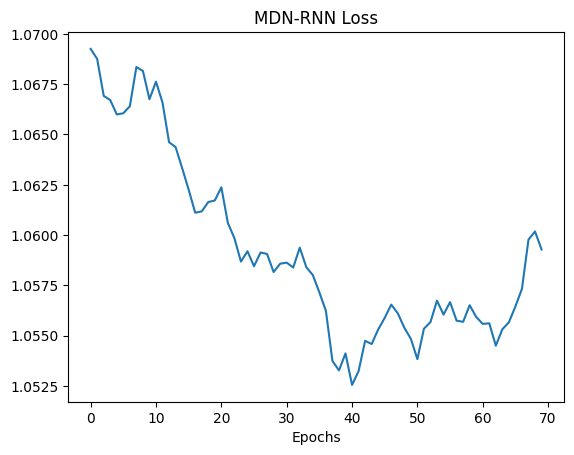

In [7]:
loss = []
with open("/home/fpkest/Mestrado/world-models/exp_dir/mdrnn_epoch_losses.txt","r") as rnn_loss_file:
    for line in rnn_loss_file.readlines():
        # print(line)
        line.split("\n")
        loss.append(float(line))

loss_avg = []
window = 30
for i in range(len(loss)-window):
    loss_avg.append(sum(loss[i:i+window])/window)    
plt.plot(loss_avg)
plt.title("MDN-RNN Loss")
plt.xlabel("Epochs")

## Define each component

In [4]:

"""
Variational encoder model, used as a visual model
for our model of the world.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    """ VAE decoder """
    def __init__(self, img_channels, latent_size):
        super(Decoder, self).__init__()
        self.latent_size = latent_size
        self.img_channels = img_channels

        self.fc1 = nn.Linear(latent_size, 1024)
        self.deconv1 = nn.ConvTranspose2d(1024, 128, 5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(32, img_channels, 6, stride=2)

    def forward(self, x): # pylint: disable=arguments-differ
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        reconstruction = F.sigmoid(self.deconv4(x))
        return reconstruction

class Encoder(nn.Module): # pylint: disable=too-many-instance-attributes
    """ VAE encoder """
    def __init__(self, img_channels, latent_size):
        super(Encoder, self).__init__()
        self.latent_size = latent_size
        #self.img_size = img_size
        self.img_channels = img_channels

        self.conv1 = nn.Conv2d(img_channels, 32, 4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2)

        self.fc_mu = nn.Linear(2*2*256, latent_size)
        self.fc_logsigma = nn.Linear(2*2*256, latent_size)


    def forward(self, x): # pylint: disable=arguments-differ
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)

        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)

        return mu, logsigma

class VAE(nn.Module):
    """ Variational Autoencoder """
    def __init__(self, img_channels, latent_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(img_channels, latent_size)
        self.decoder = Decoder(img_channels, latent_size)

    def forward(self, x): # pylint: disable=arguments-differ
        mu, logsigma = self.encoder(x)
        sigma = logsigma.exp()
        eps = torch.randn_like(sigma)
        z = eps.mul(sigma).add_(mu)

        recon_x = self.decoder(z)
        return recon_x, mu, logsigma


In [6]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

V = VAE(3,32)
count_parameters(V)

4348547

In [154]:
"""
Define MDRNN model, supposed to be used as a world model
on the latent space.
"""
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.distributions.normal import Normal

def gmm_loss(batch, mus, sigmas, logpi, reduce=True): # pylint: disable=too-many-arguments
    """ Computes the gmm loss.

    Compute minus the log probability of batch under the GMM model described
    by mus, sigmas, pi. Precisely, with bs1, bs2, ... the sizes of the batch
    dimensions (several batch dimension are useful when you have both a batch
    axis and a time step axis), gs the number of mixtures and fs the number of
    features.

    :args batch: (bs1, bs2, *, fs) torch tensor
    :args mus: (bs1, bs2, *, gs, fs) torch tensor
    :args sigmas: (bs1, bs2, *, gs, fs) torch tensor
    :args logpi: (bs1, bs2, *, gs) torch tensor
    :args reduce: if not reduce, the mean in the following formula is ommited

    :returns:
    loss(batch) = - mean_{i1=0..bs1, i2=0..bs2, ...} log(
        sum_{k=1..gs} pi[i1, i2, ..., k] * N(
            batch[i1, i2, ..., :] | mus[i1, i2, ..., k, :], sigmas[i1, i2, ..., k, :]))

    NOTE: The loss is not reduced along the feature dimension (i.e. it should scale ~linearily
    with fs).
    """
    batch = batch.unsqueeze(-2)
    normal_dist = Normal(mus, sigmas)
    g_log_probs = normal_dist.log_prob(batch)
    g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
    max_log_probs = torch.max(g_log_probs, dim=-1, keepdim=True)[0]
    g_log_probs = g_log_probs - max_log_probs

    g_probs = torch.exp(g_log_probs)
    probs = torch.sum(g_probs, dim=-1)

    log_prob = max_log_probs.squeeze() + torch.log(probs)
    if reduce:
        return - torch.mean(log_prob)
    return - log_prob

class _MDRNNBase(nn.Module):
    def __init__(self, latents, actions, hiddens, gaussians):
        super().__init__()
        self.latents = latents
        self.actions = actions
        self.hiddens = hiddens
        self.gaussians = gaussians

        self.gmm_linear = nn.Linear(
            hiddens, (2 * latents + 1) * gaussians + 2)

    def forward(self, *inputs):
        pass

class MDRNN(_MDRNNBase):
    """ MDRNN model for multi steps forward """
    def __init__(self, latents, actions, hiddens, gaussians):
        super().__init__(latents, actions, hiddens, gaussians)
        self.rnn = nn.LSTM(latents + actions, hiddens)

    def forward(self, actions, latents): # pylint: disable=arguments-differ
        """ MULTI STEPS forward.

        :args actions: (SEQ_LEN, BSIZE, ASIZE) torch tensor
        :args latents: (SEQ_LEN, BSIZE, LSIZE) torch tensor

        :returns: mu_nlat, sig_nlat, pi_nlat, rs, ds, parameters of the GMM
        prediction for the next latent, gaussian prediction of the reward and
        logit prediction of terminality.
            - mu_nlat: (SEQ_LEN, BSIZE, N_GAUSS, LSIZE) torch tensor
            - sigma_nlat: (SEQ_LEN, BSIZE, N_GAUSS, LSIZE) torch tensor
            - logpi_nlat: (SEQ_LEN, BSIZE, N_GAUSS) torch tensor
            - rs: (SEQ_LEN, BSIZE) torch tensor
            - ds: (SEQ_LEN, BSIZE) torch tensor
        """
        seq_len, bs = actions.size(0), actions.size(1)

        ins = torch.cat([actions, latents], dim=-1)
        outs, _ = self.rnn(ins)
        gmm_outs = self.gmm_linear(outs)

        stride = self.gaussians * self.latents

        mus = gmm_outs[:, :, :stride]
        mus = mus.view(seq_len, bs, self.gaussians, self.latents)

        sigmas = gmm_outs[:, :, stride:2 * stride]
        sigmas = sigmas.view(seq_len, bs, self.gaussians, self.latents)
        sigmas = torch.exp(sigmas)

        pi = gmm_outs[:, :, 2 * stride: 2 * stride + self.gaussians]
        pi = pi.view(seq_len, bs, self.gaussians)
        logpi = f.log_softmax(pi, dim=-1)

        rs = gmm_outs[:, :, -2]

        ds = gmm_outs[:, :, -1]

        return mus, sigmas, logpi, rs, ds

class MDRNNCell(_MDRNNBase):
    """ MDRNN model for one step forward """
    def __init__(self, latents, actions, hiddens, gaussians):
        super().__init__(latents, actions, hiddens, gaussians)
        self.rnn = nn.LSTMCell(latents + actions, hiddens)

    def forward(self, action, latent, hidden): # pylint: disable=arguments-differ
        """ ONE STEP forward.

        :args actions: (BSIZE, ASIZE) torch tensor
        :args latents: (BSIZE, LSIZE) torch tensor
        :args hidden: (BSIZE, RSIZE) torch tensor

        :returns: mu_nlat, sig_nlat, pi_nlat, r, d, next_hidden, parameters of
        the GMM prediction for the next latent, gaussian prediction of the
        reward, logit prediction of terminality and next hidden state.
            - mu_nlat: (BSIZE, N_GAUSS, LSIZE) torch tensor
            - sigma_nlat: (BSIZE, N_GAUSS, LSIZE) torch tensor
            - logpi_nlat: (BSIZE, N_GAUSS) torch tensor
            - rs: (BSIZE) torch tensor
            - ds: (BSIZE) torch tensor
        """
        in_al = torch.cat([action, latent], dim=1)

        next_hidden = self.rnn(in_al, hidden)
        out_rnn = next_hidden[0]

        out_full = self.gmm_linear(out_rnn)

        stride = self.gaussians * self.latents

        mus = out_full[:, :stride]
        mus = mus.view(-1, self.gaussians, self.latents)

        sigmas = out_full[:, stride:2 * stride]
        sigmas = sigmas.view(-1, self.gaussians, self.latents)
        sigmas = torch.exp(sigmas)

        pi = out_full[:, 2 * stride:2 * stride + self.gaussians]
        pi = pi.view(-1, self.gaussians)
        logpi = f.log_softmax(pi, dim=-1)

        r = out_full[:, -2]

        d = out_full[:, -1]

        return mus, sigmas, logpi, r, d, next_hidden


In [155]:
""" Define controller """
import torch
import torch.nn as nn

class Controller(nn.Module):
    """ Controller """
    def __init__(self, latents, recurrents, actions):
        super().__init__()
        self.fc = nn.Linear(latents + recurrents, actions)

    def forward(self, *inputs):
        cat_in = torch.cat(inputs, dim=1)
        return self.fc(cat_in)



## Get rollout of experiences in environment

In [8]:
import math 

# Hardcoded for now
ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE =\
    3, 32, 256, 64, 64

# Same
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((RED_SIZE, RED_SIZE)),
    transforms.ToTensor()
])

def sample_continuous_policy(action_space, seq_len, dt):
    """ Sample a continuous policy.

    Atm, action_space is supposed to be a box environment. The policy is
    sampled as a brownian motion a_{t+1} = a_t + sqrt(dt) N(0, 1).

    :args action_space: gym action space
    :args seq_len: number of actions returned
    :args dt: temporal discretization

    :returns: sequence of seq_len actions
    """
    actions = [action_space.sample()]
    for _ in range(seq_len):
        daction_dt = np.random.randn(*actions[-1].shape)
        actions.append(
            np.clip(actions[-1] + math.sqrt(dt) * daction_dt,
                    action_space.low, action_space.high))
    return actions

def save_checkpoint(state, is_best, filename, best_filename):
    """ Save state in filename. Also save in best_filename if is_best. """
    torch.save(state, filename)
    if is_best:
        torch.save(state, best_filename)

def flatten_parameters(params):
    """ Flattening parameters.

    :args params: generator of parameters (as returned by module.parameters())

    :returns: flattened parameters (i.e. one tensor of dimension 1 with all
        parameters concatenated)
    """
    return torch.cat([p.detach().view(-1) for p in params], dim=0).cpu().numpy()

def unflatten_parameters(params, example, device):
    """ Unflatten parameters.

    :args params: parameters as a single 1D np array
    :args example: generator of parameters (as returned by module.parameters()),
        used to reshape params
    :args device: where to store unflattened parameters

    :returns: unflattened parameters
    """
    params = torch.Tensor(params).to(device)
    idx = 0
    unflattened = []
    for e_p in example:
        unflattened += [params[idx:idx + e_p.numel()].view(e_p.size())]
        idx += e_p.numel()
    return unflattened

def load_parameters(params, controller):
    """ Load flattened parameters into controller.

    :args params: parameters as a single 1D np array
    :args controller: module in which params is loaded
    """
    proto = next(controller.parameters())
    params = unflatten_parameters(
        params, controller.parameters(), proto.device)

    for p, p_0 in zip(controller.parameters(), params):
        p.data.copy_(p_0)
        
class RolloutGenerator(object):
    """ Utility to generate rollouts.

    Encapsulate everything that is needed to generate rollouts in the TRUE ENV
    using a controller with previously trained VAE and MDRNN.

    :attr vae: VAE model loaded from mdir/vae
    :attr mdrnn: MDRNN model loaded from mdir/mdrnn
    :attr controller: Controller, either loaded from mdir/ctrl or randomly
        initialized
    :attr env: instance of the CarRacing-v0 gym environment
    :attr device: device used to run VAE, MDRNN and Controller
    :attr time_limit: rollouts have a maximum of time_limit timesteps
    """
    def __init__(self, mdir, device, time_limit):
        """ Build vae, rnn, controller and environment. """
        # Loading world model and vae
        vae_file, rnn_file, ctrl_file = \
            [join(mdir, m, 'best.tar') for m in ['vae', 'mdrnn', 'ctrl']]

        assert exists(vae_file) and exists(rnn_file),\
            "Either vae or mdrnn is untrained."

        vae_state, rnn_state = [
            torch.load(fname, map_location={'cuda:0': str(device)})
            for fname in (vae_file, rnn_file)]

        for m, s in (('VAE', vae_state), ('MDRNN', rnn_state)):
            print("Loading {} at epoch {} "
                  "with test loss {}".format(
                      m, s['epoch'], s['precision']))

        self.vae = VAE(3, LSIZE).to(device)
        self.vae.load_state_dict(vae_state['state_dict'])

        self.mdrnn = MDRNNCell(LSIZE, ASIZE, RSIZE, 5).to(device)
        self.mdrnn.load_state_dict(
            {k.strip('_l0'): v for k, v in rnn_state['state_dict'].items()})

        self.controller = Controller(LSIZE, RSIZE, ASIZE).to(device)

        # load controller if it was previously saved
        if exists(ctrl_file):
            ctrl_state = torch.load(ctrl_file, map_location={'cuda:0': str(device)})
            print("Loading Controller with reward {}".format(
                ctrl_state['reward']))
            self.controller.load_state_dict(ctrl_state['state_dict'])

        self.env = gym.make('CarRacing-v2')
        self.device = device

        self.time_limit = time_limit

    def get_action_and_transition(self, obs, hidden):
        """ Get action and transition.

        Encode obs to latent using the VAE, then obtain estimation for next
        latent and next hidden state using the MDRNN and compute the controller
        corresponding action.

        :args obs: current observation (1 x 3 x 64 x 64) torch tensor
        :args hidden: current hidden state (1 x 256) torch tensor

        :returns: (action, next_hidden)
            - action: 1D np array
            - next_hidden (1 x 256) torch tensor
        """
        print("")
        _, latent_mu, _ = self.vae(obs)
        action = self.controller(latent_mu, hidden[0])
        _, _, _, _, _, next_hidden = self.mdrnn(action, latent_mu, hidden)
        return action.squeeze().cpu().detach().numpy(), next_hidden

    def rollout(self, params, render=False):
        """ Execute a rollout and returns minus cumulative reward.

        Load :params: into the controller and execute a single rollout. This
        is the main API of this class.

        :args params: parameters as a single 1D np array

        :returns: minus cumulative reward
        """
        # copy params into the controller
        if params is not None:
            load_parameters(params, self.controller)

        obs = self.env.reset()

        # This first render is required !
        self.env.render()

        hidden = [
            torch.zeros(1, RSIZE).to(self.device)
            for _ in range(2)]

        cumulative = 0
        i = 0
        while True:
            obs = transform(obs).unsqueeze(0).to(self.device)
            action, hidden = self.get_action_and_transition(obs, hidden)
            obs, reward, done, _ = self.env.step(action)

            if render:
                self.env.render()

            cumulative += reward
            if done or i > self.time_limit:
                return - cumulative
            i += 1

# Test whole Model

In [1]:
from test_controller import test_controller

test_controller()

Loading VAE at epoch 24 with test loss 27.706628288879394
Loading MDRNN at epoch 26 with test loss 1.0593049264151202


RuntimeError: Error(s) in loading state_dict for MDRNNCell:
	size mismatch for gmm_linear.weight: copying a param with shape torch.Size([327, 256]) from checkpoint, the shape in current model is torch.Size([647, 256]).
	size mismatch for gmm_linear.bias: copying a param with shape torch.Size([327]) from checkpoint, the shape in current model is torch.Size([647]).
	size mismatch for rnn.weight_ih: copying a param with shape torch.Size([1024, 35]) from checkpoint, the shape in current model is torch.Size([1024, 67]).